
# Uso de variables numéricas y categóricas juntas

Anteriormente, se mostró el preprocesamiento necesario cuando se trata con variables numéricas y categóricas. Sin embargo, separamos el proceso para tratar cada tipo de forma individual. En este notebook, aprenderás cómo combinar estos pasos de preprocesamiento.

Primero, cargamos todo el conjunto de datos del censo de adultos.

In [ ]:
import pandas as pd

adult_census = pd.read_csv("adult.csv")
# drop the duplicated column `"education-num"` as stated in the first notebook
adult_census = adult_census.drop(columns="education.num")

target_name = "income"
target = adult_census[target_name]

data = adult_census.drop(columns=[target_name])

## Selección basada en tipos de datos

Separamos las variables categóricas y numéricas utilizando sus tipos de datos para identificarlas, ya que vimos anteriormente que `object` corresponde a las columnas categóricas (cadenas de texto). Usamos el asistente `make_column_selector` para seleccionar las columnas correspondientes.


In [ ]:
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(data)
categorical_columns = categorical_columns_selector(data)

¡Precaución!
Aquí, sabemos que el tipo de dato `object` se usa para representar cadenas de texto y, por lo tanto, características categóricas. Ten en cuenta que esto no siempre es así. A veces, el tipo de dato `object` podría contener otro tipo de información, como fechas que no se han formateado correctamente (cadenas de texto) y que, sin embargo, se relacionan con una cantidad de tiempo transcurrido. En un escenario más general, deberías inspeccionar manualmente el contenido de tu dataframe para no utilizar incorrectamente `make_column_selector`.


## Asignar columnas a un procesador específico

En las secciones anteriores, vimos que necesitamos tratar los datos de manera diferente dependiendo de su naturaleza (es decir, numérica o categórica).

Scikit-learn proporciona una clase llamada `ColumnTransformer`, que envía columnas específicas a un transformador específico, lo que facilita ajustar un único modelo predictivo en un conjunto de datos que combina ambos tipos de variables (datos tabulares con tipos heterogéneos).

Primero, definimos las columnas dependiendo de su tipo de dato:

* Se aplica **codificación one-hot** a las columnas categóricas. Además, usamos `handle_unknown="ignore"` para resolver los posibles problemas debido a categorías raras.
* **Escalado numérico** para las características numéricas, que serán estandarizadas.

Ahora, creamos nuestro `ColumnTransformer` especificando tres valores: el nombre del preprocesador, el transformador y las columnas. Primero, vamos a crear los preprocesadores para las partes numéricas y categóricas.


In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

Ahora, creamos el transformador y asociamos cada uno de estos preprocesadores con sus respectivas columnas.

In [ ]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    [
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
        ("standard_scaler", numerical_preprocessor, numerical_columns),
    ]
)

Podemos tomarnos un minuto para representar gráficamente la estructura de un `ColumnTransformer`:




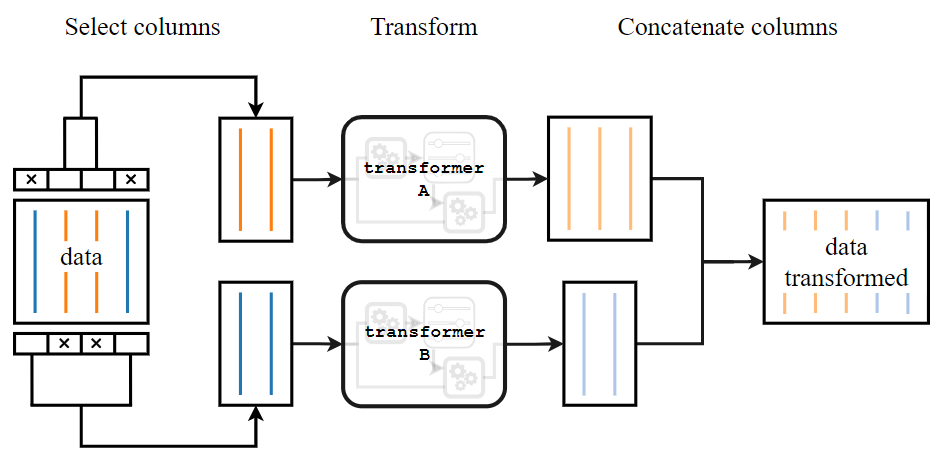


Un `ColumnTransformer` realiza lo siguiente:

* **Divide las columnas** del conjunto de datos original en función de los nombres o índices de columna proporcionados. Obtenemos tantos subconjuntos como el número de transformadores que se pasen al `ColumnTransformer`.
* **Transforma cada subconjunto**. Se aplica un transformador específico a cada subconjunto: internamente, llama a `fit_transform` o `transform`. El resultado de este paso es un conjunto de datos transformados.
* Luego, **concatena los conjuntos de datos transformados** en un solo conjunto de datos.

Lo importante es que `ColumnTransformer` es como cualquier otro transformador de scikit-learn. En particular, se puede combinar con un clasificador en un `Pipeline`:


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(preprocessor, LogisticRegression(max_iter=500))
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital.status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native.country']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['age', 'fnlwgt',
                                                   'capital.gain',
                                                   'capital.loss',
                                                   'hours.per.week'])])),
                ('logisticregression', LogisticRegression(max_iter=500))])

El modelo final es más complejo que los modelos anteriores, pero sigue utilizando la misma API (el mismo conjunto de métodos que puede llamar el usuario):

- El método `fit` se llama para preprocesar los datos y luego entrenar el clasificador con los datos preprocesados;
- El método `predict` hace predicciones sobre datos nuevos;
- El método `score` se utiliza para predecir en los datos de prueba y comparar las predicciones con las etiquetas de prueba esperadas para calcular la precisión.

Empecemos dividiendo nuestros datos en conjuntos de entrenamiento y prueba.


In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42
)

¡Precaución!
Ten en cuenta que aquí usamos `train_test_split` con fines didácticos, para mostrar la API de scikit-learn. En un entorno real, se podría preferir utilizar la validación cruzada para poder evaluar también la incertidumbre de nuestra estimación del rendimiento de generalización de un modelo, como se demostró anteriormente.

Ahora, podemos entrenar el modelo en el conjunto de entrenamiento.


In [ ]:
_ = model.fit(data_train, target_train)

Luego, podemos enviar el conjunto de datos sin procesar directamente al `pipeline`. De hecho, no necesitamos realizar ningún preprocesamiento manual (llamando a los métodos `transform` o `fit_transform`) ya que esto se gestiona automáticamente cuando llamamos al método `predict`. Como ejemplo, predecimos en las cinco primeras muestras del conjunto de prueba.


In [ ]:
data_test.head()

,age,workclass,fnlwgt,education,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
14160,29,Private,280618,Some-college,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States
27048,19,Private,439779,Some-college,Never-married,Sales,Own-child,White,Male,0,0,15,United-States
28868,28,Private,204734,Some-college,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,40,United-States
5667,35,Private,107991,11th,Never-married,Sales,Not-in-family,White,Male,0,0,45,United-States
7827,20,Private,54152,Some-college,Never-married,Adm-clerical,Own-child,White,Female,0,0,30,?


In [ ]:
model.predict(data_test)[:5]

array(['<=50K', '<=50K', '<=50K', '<=50K', '<=50K'], dtype=object)

In [ ]:
target_test[:5]

,income
14160,<=50K
27048,<=50K
28868,<=50K
5667,<=50K
7827,<=50K


Para obtener directamente la puntuación de precisión, necesitamos llamar al método `score`. Vamos a calcular la precisión en todo el conjunto de prueba.


In [ ]:
model.score(data_test, target_test)

0.8482987347991647

## Evaluación del modelo con validación cruzada

Como se mencionó anteriormente, un modelo predictivo debe evaluarse mediante validación cruzada. Nuestro modelo se puede utilizar con las herramientas de validación cruzada de scikit-learn, al igual que cualquier otro predictor:


In [ ]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, data, target, cv=5)
cv_results

{'fit_time': array([0.25947309, 0.29407573, 0.24021077, 0.28450108, 0.2863276 ]),
 'score_time': array([0.03155065, 0.02974725, 0.02963829, 0.03046989, 0.03127694]),
 'test_score': array([0.77660064, 0.87346437, 0.82263514, 0.83277027, 0.82616708])}

In [ ]:
scores = cv_results["test_score"]
print(
    "The mean cross-validation accuracy is: "
    f"{scores.mean():.3f} ± {scores.std():.3f}"
)

The mean cross-validation accuracy is: 0.826 ± 0.031


De este ejercicio podemos concluir que el modelo compuesto (con variables numéricas y categóricas) tiene una mayor precisión predictiva que los dos modelos que usaron variables numéricas y categóricas de forma aislada.


## Ajuste de un modelo más potente

Los **modelos lineales** son interesantes porque generalmente son baratos de entrenar, **pequeños** para implementar, **rápidos** para predecir y proporcionan un **buen punto de partida**.

Sin embargo, a menudo es útil verificar si modelos más complejos, como un conjunto de árboles de decisión, pueden ofrecer un mejor rendimiento predictivo. En esta sección utilizamos un modelo de este tipo llamado **árboles de gradiente potenciado** y evaluamos su capacidad de generalización. Más concretamente, el modelo de scikit-learn que utilizamos se llama `HistGradientBoostingClassifier`. Ten en cuenta que los modelos de potenciación (boosting) se cubrirán con más detalle en las siguientes sesiones.

Para los modelos basados en árboles, el manejo de variables numéricas y categóricas es más sencillo que para los modelos lineales:
* **no necesitamos escalar las características numéricas**
* usar una **codificación ordinal para las variables categóricas** está bien, incluso si la codificación resulta en un orden arbitrario

Por lo tanto, para el `HistGradientBoostingClassifier`, la canalización de preprocesamiento es ligeramente más simple que la que vimos anteriormente para el `LogisticRegression`:


In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder

categorical_preprocessor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)

preprocessor = ColumnTransformer(
    [("categorical", categorical_preprocessor, categorical_columns)],
    remainder="passthrough",
)

model = make_pipeline(preprocessor, HistGradientBoostingClassifier())

Ahora que hemos creado nuestro modelo, podemos verificar su capacidad de generalización.


In [ ]:
_ = model.fit(data_train, target_train)

In [ ]:
model.score(data_test, target_test)

0.8727429062768701


Podemos observar que obtenemos precisiones significativamente más altas con el modelo de Gradient Boosting. Esto es a menudo lo que observamos cuando el conjunto de datos tiene un gran número de muestras y un número limitado de características informativas (por ejemplo, menos de 1000) con una combinación de variables numéricas y categóricas.

Esto explica por qué las máquinas de Gradient Boosting son muy populares entre los profesionales de la ciencia de datos que trabajan con datos tabulares.


En este notebok:

- Utilizamos un **ColumnTransformer** para aplicar diferentes preprocesamientos a variables categóricas y numéricas.
- Usamos una **pipeline** para encadenar el preprocesamiento con **ColumnTransformer** y el ajuste de **regresión logística**.
- Observamos que los métodos de **boosting de gradiente** pueden superar a los modelos lineales.
